In [4]:
import numpy as np
import pandas as pd
import random
import os
import gc
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from keras.models import Sequential
import datetime as dt
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint, TensorBoard
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler

In [5]:
data = pd.read_csv("outputs/194.csv")
#train = data.iloc[0:1200,:]
#test = data.iloc[1200:1220,:]
train = pd.read_csv("outputs/filled_train_data194_PCA09.csv")
test = pd.read_csv("outputs/filled_test_data194_PCA09.csv")

In [6]:
train

,target,0,1,2,3,4,5,6,7,8,...,59,60,61,62,63,64,65,66,67,68
0,-0.167222,-4.783668,0.069418,-4.864057,-3.130580,3.136805,0.754584,-2.191258,-2.187817,0.332244,...,-1.378773,0.353806,-0.474709,1.204346,0.201978,0.333042,0.799538,0.054127,-0.768876,-0.166666
1,0.497589,-7.356303,0.696312,-0.411787,2.363241,3.725213,2.986429,-5.236173,-2.171918,0.092867,...,-0.955815,0.251038,-0.194074,1.118333,-0.581601,1.027060,0.606822,0.035413,-1.258977,-0.824911
2,0.131961,-6.752898,-0.864622,-3.365706,-1.261599,2.874436,2.711764,-3.459663,-0.658052,-1.953237,...,-0.595932,0.620424,-0.338101,0.451789,0.131094,0.175788,0.337508,0.480333,-1.570717,-0.102814
3,-0.407528,-4.634332,1.075730,-3.603383,-1.108518,4.557188,-0.196418,-3.486228,-0.961260,3.466168,...,0.174623,0.479905,-0.807612,-1.134084,-0.286436,0.758677,0.051064,-0.521086,-0.748070,-0.292305
4,-0.028724,-5.403315,1.116049,-2.714679,-0.936326,4.559458,-0.188720,-4.149833,-0.079567,-3.223682,...,-0.709474,0.754365,-1.080814,0.584166,-0.406514,1.742931,-0.057343,-0.599497,-1.635263,-0.694556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,1.360528,13.379853,3.065123,0.809739,-3.996502,-2.323795,-4.030108,2.026137,0.788883,2.051896,...,-1.204319,-0.555467,0.674019,0.064425,-0.019626,2.895520,-0.501941,0.347113,1.032283,0.940238
1166,0.610404,11.184948,1.808036,4.575973,-0.332643,-1.188926,-4.074434,-1.102715,1.029989,0.188500,...,0.002600,-0.462780,0.270364,1.652924,0.656752,1.399698,-0.829669,0.395576,0.459278,-0.790491
1167,0.141646,11.718839,-4.890932,0.292321,-5.568680,-2.806554,-2.198781,0.661495,2.167179,2.719159,...,-0.171074,0.454399,0.518570,1.268375,1.154343,3.333135,0.738851,0.467051,1.577355,-1.016025
1168,0.389367,13.178778,-3.943985,2.557887,-0.317945,-3.793195,-0.666674,-1.102563,0.306401,3.031798,...,0.473396,0.236118,0.209181,1.023889,1.168769,1.463513,-0.398148,0.947965,1.121366,-2.517814


In [7]:
#standardization
train_X  = train.loc[:,train.columns != 'target']
scaler = MinMaxScaler().fit(train_X)
scaled = scaler.transform(train_X)
train_X = pd.DataFrame(scaled,columns= train_X.columns)
train_X = np.array(train_X)
train_y = train.loc[:,train.columns =="target"]
scaler = MinMaxScaler().fit(train_y)
scaled = scaler.transform(train_y)
train_y = pd.DataFrame(scaled,columns= train_y.columns)
train_y = np.array(train_y)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))

In [8]:
#train_y.to_csv('train_y.csv')
#train_X.to_csv('train_X.csv')

In [9]:
#standardization
test_X  = test.loc[:,test.columns != 'target']
scaler = MinMaxScaler().fit(test_X)
scaled = scaler.transform(test_X)
test_X = pd.DataFrame(scaled,columns= test_X.columns)
test_X = np.array(test_X)
test_y = test.loc[:,test.columns =="target"]
scaler = MinMaxScaler().fit(test_y)
scaled = scaler.transform(test_y)
test_y = pd.DataFrame(scaled,columns= test_y.columns)
test_y = np.array(test_y)
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [15]:
#Initializing the Neural Network based on LSTM
model = Sequential()
#Adding first LSTM layer
model.add(LSTM(units = 50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
#Adding second LSTM layer
model.add(LSTM(units = 10, return_sequences = False))
#Adding Dropout
model.add(Dropout(0.25))
#Output layer
model.add(Dense(1,activation = 'linear'))
#Compile the Neural Network
model.compile(optimizer= 'adam', loss='mse')
#fit the modek
model.fit(train_X, train_y, epochs=200, batch_size=600, verbose=0, shuffle=False)

In [136]:
train_X.shape

(1170, 1, 69)

In [16]:
pred_test = model.predict(test_X)

In [17]:
mean_squared_error(test_y,pred_test)

0.06366659966689449

In [18]:
pred_train = model.predict(train_X)

In [19]:
mean_squared_error(train_y,pred_train)

0.01499510761238345

In [20]:
time_id_1200 = []
time_id_20 = []
for i in range(1170):
    time_id_1200.append(i)
for i in range(1170,1220):
    time_id_20.append(i)


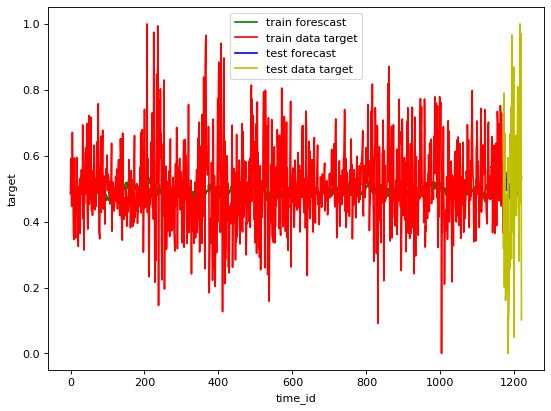

In [21]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.plot(time_id_1200,pred_train,color = "g",label = 'train pred')
plt.plot(time_id_1200,train_y,color = "r")
plt.plot(time_id_20,pred_test,color = "b")
plt.plot(time_id_20,test_y,color = "y")
plt.ylabel("target")
plt.xlabel("time_id")
plt.legend(['train forescast', 'train data target','test forecast','test data target'])
#plt.show()
#figure(figsize=(32, 6), dpi=80)
#plt.plot(time_id,train_y,color = "b")
plt.show()